# Libraries Setup

In [ ]:
# Install required libraries
!pip install numpy pandas scikit-learn matplotlib tensorflow keras

   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.9 MB 487.6 kB/s eta 0:00:31
   --- ------------------------------------ 1.2/14.9 MB 8.4 MB/s eta 0:00:02
   -------- ------------------------------- 3.1/14.9 MB 16.3 MB/s eta 0:00:01
   -------- ------------------------------- 3.2/14.9 MB 13.6 MB/s eta 0:00:01
   -------- ------------------------------- 3.2/14.9 MB 12.9 MB/s eta 0:00:01
   -------- ------------------------------- 3.2/14.9 MB 12.9 MB/s eta 0:00:01
   -------- ------------------------------- 3.3/14.9 MB 8.9 MB/s eta 0:00:02
   --------- ------------------------------ 3.5/14.9 MB 8.2 MB/s eta 0:00:02
   --------- ------------------------------ 3.5/14.9 MB 8.3 MB/s eta 0:00:02
   --------- ------------------------------ 3.5/14.9 MB 8.3 MB/s eta 0:00:02
   --------- ------------------------------ 3.6/14.9 MB 6.5 MB/s eta 0:00:02
   ----

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
pydantic 2.7.4 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.18.4 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Preprocessing

In [2]:
ROOT ='data/'

In [3]:
# Load the dataset
train_url = ROOT + 'UNSW_NB15_training-set.parquet'
test_url = ROOT + 'UNSW_NB15_testing-set.parquet'

train_data = pd.read_parquet(train_url)
test_data = pd.read_parquet(test_url)

In [4]:
# Inspect the dataset
print(train_data.head())

        dur proto service state  spkts  dpkts  sbytes  dbytes          rate  \
0  0.000011   udp       -   INT      2      0     496       0   90909.09375   
1  0.000008   udp       -   INT      2      0    1762       0  125000.00000   
2  0.000005   udp       -   INT      2      0    1068       0  200000.00000   
3  0.000006   udp       -   INT      2      0     900       0  166666.65625   
4  0.000010   udp       -   INT      2      0    2126       0  100000.00000   

         sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  180363632.0  ...            0                  0                 1   
1  881000000.0  ...            0                  0                 1   
2  854400000.0  ...            0                  0                 1   
3  600000000.0  ...            0                  0                 2   
4  850400000.0  ...            0                  0                 2   

   ct_dst_sport_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
0                 1

In [5]:
train_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.093750,1.803636e+08,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000000,8.810000e+08,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.000000,8.544000e+08,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.656250,6.000000e+08,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.000000,8.504000e+08,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.000000,8.320000e+07,...,0,0,1,1,0,0,0,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,1.241044e+05,...,0,0,1,1,0,0,0,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0


In [6]:
# Preprocess the dataset
# Drop non-numeric columns (4 columns)
train_data = train_data.select_dtypes(include=[np.number]).dropna()
test_data = test_data.select_dtypes(include=[np.number]).dropna()

In [7]:
train_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
0,0.000011,2,0,496,0,90909.093750,1.803636e+08,0.000000,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0.000008,2,0,1762,0,125000.000000,8.810000e+08,0.000000,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0.000005,2,0,1068,0,200000.000000,8.544000e+08,0.000000,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0.000006,2,0,900,0,166666.656250,6.000000e+08,0.000000,0,0,...,0,0,0,2,1,0,0,0,0,0
4,0.000010,2,0,2126,0,100000.000000,8.504000e+08,0.000000,0,0,...,0,0,0,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,2,0,104,0,200000.000000,8.320000e+07,0.000000,0,0,...,0,0,0,1,1,0,0,0,0,0
82328,1.106101,20,8,18062,354,24.410067,1.241044e+05,2242.109863,7,1,...,44,0,0,1,1,0,0,0,0,0
82329,0.000000,1,0,46,0,0.000000,0.000000e+00,0.000000,0,0,...,0,0,0,1,1,0,0,0,1,0
82330,0.000000,1,0,46,0,0.000000,0.000000e+00,0.000000,0,0,...,0,0,0,1,1,0,0,0,1,0


In [8]:
test_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
0,0.121478,6,4,258,172,74.087486,1.415894e+04,8495.365234,0,0,...,43,0,0,1,1,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473373,8.395112e+03,503571.312500,2,17,...,1106,0,0,1,1,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,1.572272e+03,60929.230469,1,6,...,824,0,0,1,1,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,2.740179e+03,3358.622070,1,3,...,64,0,0,1,1,1,1,0,0,0
4,0.449454,10,6,534,268,33.373825,8.561499e+03,3987.059814,2,1,...,45,0,0,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,2,0,114,0,111111.109375,5.066666e+07,0.000000,0,0,...,0,0,0,24,13,0,0,0,0,1
175337,0.505762,10,8,620,354,33.612648,8.826286e+03,4903.492188,2,1,...,44,0,0,1,1,0,0,0,0,1
175338,0.000009,2,0,114,0,111111.109375,5.066666e+07,0.000000,0,0,...,0,0,0,3,3,0,0,0,0,1
175339,0.000009,2,0,114,0,111111.109375,5.066666e+07,0.000000,0,0,...,0,0,0,30,14,0,0,0,0,1


In [9]:
# Split into features and labels
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

In [10]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Clustering Models

## Isolation Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],  # Number of base estimators in the ensemble
    'contamination': [0.05, 0.1, 0.2],  # The amount of contamination of the data set, i.e., the proportion of outliers
    'max_features': [1.0, 0.5],  # The number of features to draw from X to train each base estimator
}

In [ ]:
# Custom scoring function for GridSearchCV
def unsupervised_score(estimator, X):
    # Predict the anomaly scores (lower means more anomalous)
    scores = estimator.decision_function(X)
    # Since GridSearchCV maximizes the score, we need to negate the anomaly scores
    return np.mean(scores)

In [ ]:
scorer = make_scorer(unsupervised_score, greater_is_better=True)

In [ ]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1, verbose=1)

# Perform the grid search on the scaled training data
grid_search.fit(X_train_scaled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=IsolationForest(random_state=42), n_jobs=-1,
             param_grid={'contamination': [0.05, 0.1, 0.2],
                         'max_features': [1.0, 0.5],
                         'n_estimators': [50, 100]},
             scoring=make_scorer(unsupervised_score), verbose=1)

In [ ]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_params)

Best parameters found by GridSearchCV: {'contamination': 0.05, 'max_features': 1.0, 'n_estimators': 50}


In [ ]:
# Train the Isolation Forest with the best parameters
best_iso_forest = IsolationForest(**best_params, random_state=42)
best_iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.05, n_estimators=50, random_state=42)

In [ ]:
# Predict anomalies
y_pred_best_iso_forest = best_iso_forest.predict(X_test_scaled)
y_pred_best_iso_forest = np.where(y_pred_best_iso_forest == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [ ]:
# Evaluate
print("Best Isolation Forest")
print(classification_report(y_test, y_pred_best_iso_forest))

Best Isolation Forest
              precision    recall  f1-score   support

           0       0.32      0.93      0.47     56000
           1       0.64      0.05      0.10    119341

    accuracy                           0.34    175341
   macro avg       0.48      0.49      0.29    175341
weighted avg       0.54      0.34      0.22    175341



In [ ]:
from sklearn.tree import export_text

# Access individual trees from the trained Isolation Forest
trees = best_iso_forest.estimators_

# Example: print the structure of the first tree
for i, tree in enumerate(trees):
    print(f"Tree {i}")
    print(export_text(tree, feature_names=X_train.columns.to_list()))
    print("\n" + "-"*50 + "\n")


Tree 0
|--- swin <= -0.09
|   |--- sload <= 2.65
|   |   |--- sjit <= -0.11
|   |   |   |--- sinpkt <= 0.10
|   |   |   |   |--- spkts <= 0.10
|   |   |   |   |   |--- smean <= 0.98
|   |   |   |   |   |   |--- smean <= 0.55
|   |   |   |   |   |   |   |--- dinpkt <= -0.09
|   |   |   |   |   |   |   |   |--- value: [0.54]
|   |   |   |   |   |   |   |--- dinpkt >  -0.09
|   |   |   |   |   |   |   |   |--- value: [0.71]
|   |   |   |   |   |   |--- smean >  0.55
|   |   |   |   |   |   |   |--- value: [0.58]
|   |   |   |   |   |--- smean >  0.98
|   |   |   |   |   |   |--- dbytes <= -0.08
|   |   |   |   |   |   |   |--- ct_src_dport_ltm <= 0.00
|   |   |   |   |   |   |   |   |--- value: [0.56]
|   |   |   |   |   |   |   |--- ct_src_dport_ltm >  0.00
|   |   |   |   |   |   |   |   |--- value: [0.51]
|   |   |   |   |   |   |--- dbytes >  -0.08
|   |   |   |   |   |   |   |--- value: [0.37]
|   |   |   |   |--- spkts >  0.10
|   |   |   |   |   |--- value: [0.20]
|   |   |   |--- 

## One-Class SVM

In [ ]:
# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
oc_svm.fit(X_train_scaled)

OneClassSVM(gamma='auto')

In [ ]:
# Predict anomalies
y_pred_oc_svm = oc_svm.predict(X_test_scaled)
y_pred_oc_svm = np.where(y_pred_oc_svm == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [ ]:
# Evaluate
print("One-Class SVM")
print(classification_report(y_test, y_pred_oc_svm))

One-Class SVM
              precision    recall  f1-score   support

           0       0.31      0.45      0.36     56000
           1       0.67      0.52      0.59    119341

    accuracy                           0.50    175341
   macro avg       0.49      0.48      0.47    175341
weighted avg       0.55      0.50      0.51    175341



## DBSCAN

In [ ]:
pip install threadpoolctl==3.1.0

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Take a random sample from the dataset
sample_size = 50000
data_sample = test_data.sample(n=sample_size, random_state=42)

In [19]:
# Split features and target
X_sample = data_sample.drop(columns='label')
y_sample = data_sample['label']

In [20]:
# Scale the data
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

In [21]:
# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)

In [22]:
# Compute clusters from data and predict labels
y_pred_dbscan = dbscan.fit_predict(X_sample_scaled)

In [23]:
# Convert to 0 (normal) and 1 (anomaly)
y_pred_dbscan = np.where(y_pred_dbscan == -1, 1, 0)

In [24]:
# Evaluate
print("DBSCAN")
print(classification_report(y_sample, y_pred_dbscan))

DBSCAN
              precision    recall  f1-score   support

           0       0.32      0.99      0.48     15953
           1       0.66      0.01      0.01     34047

    accuracy                           0.32     50000
   macro avg       0.49      0.50      0.25     50000
weighted avg       0.55      0.32      0.16     50000



# LSTM for Sequential Patterns

In [11]:
# Prepare the data for LSTM
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [30]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy')

In [31]:
# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
1030/1030 [==============================] - 6s 3ms/step - loss: 0.2407 - val_loss: 1.7543
Epoch 2/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1449 - val_loss: 1.5853
Epoch 3/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1312 - val_loss: 1.4770
Epoch 4/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1227 - val_loss: 1.4019
Epoch 5/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1177 - val_loss: 1.4942
Epoch 6/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1141 - val_loss: 1.4563
Epoch 7/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1112 - val_loss: 1.2189
Epoch 8/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1088 - val_loss: 1.3412
Epoch 9/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.1068 - val_loss: 1.4580
Epoch 10/10
1030/1030 [==============================] - 3s 3ms/step - loss: 0.105

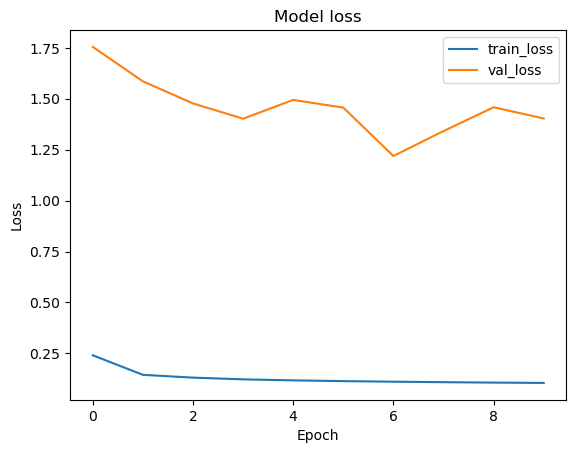

In [32]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])
plt.show()

In [38]:
# Predict and evaluate
y_pred_lstm_prob = model.predict(X_test_lstm)
y_pred_lstm = np.where(y_pred_lstm_prob > 0.5, 1, 0)

5480/5480 [==============================] - 10s 2ms/step


In [39]:
print("LSTM")
print(classification_report(y_test, y_pred_lstm))

LSTM
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     56000
           1       0.91      0.99      0.95    119341

    accuracy                           0.93    175341
   macro avg       0.94      0.89      0.91    175341
weighted avg       0.93      0.93      0.92    175341



In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[ 44897  11103]
 [  1752 117589]]


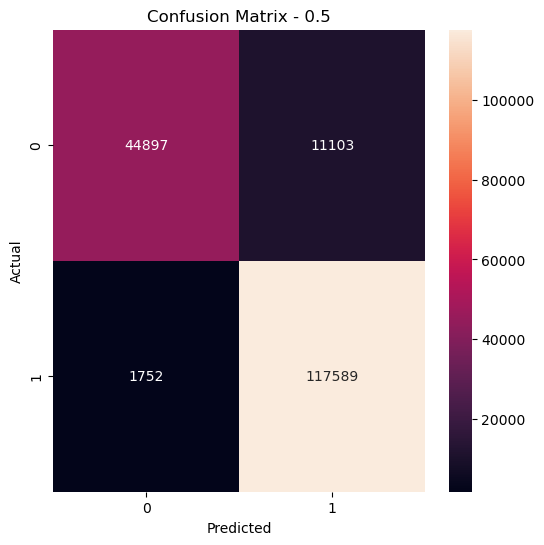

In [43]:
treshold = 0.5
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.title('Confusion Matrix - {}'.format(treshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

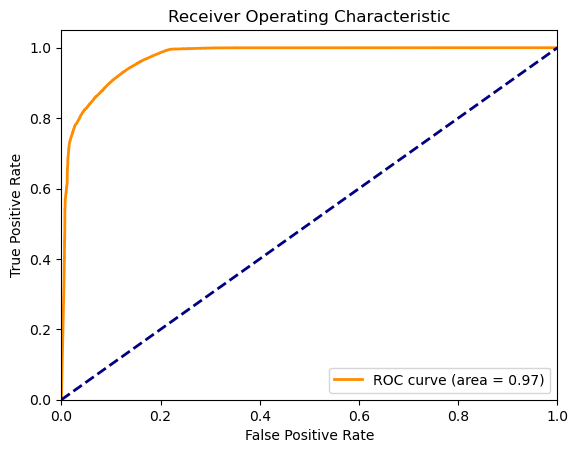

In [42]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Semi-Supervised Learning

In [11]:
NUM_ITERATIONS = 5

In [12]:
# Initialize the model (using Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)

In [13]:
# Iterative training
for _ in range(NUM_ITERATIONS):  # Number of iterations
    model.fit(X_train_scaled)
    y_pred = model.predict(X_train_scaled)
    high_confidence = np.where(y_pred == 1, True, False)
    
    # Add high-confidence predictions to the training set
    X_train_scaled = np.concatenate([X_train_scaled, X_train_scaled[high_confidence]], axis=0)
    y_train = np.concatenate([y_train, y_pred[high_confidence]], axis=0)

In [14]:
# Final prediction on test set
y_pred = model.predict(X_test_scaled)
y_pred = np.where(y_pred == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [15]:
# Evaluate
print("Semi-Supervised Learning")
print(classification_report(y_test, y_pred))

Semi-Supervised Learning
              precision    recall  f1-score   support

           0       0.25      0.58      0.35     56000
           1       0.49      0.19      0.27    119341

    accuracy                           0.32    175341
   macro avg       0.37      0.39      0.31    175341
weighted avg       0.42      0.32      0.30    175341

